In [1]:
%matplotlib inline


# Tutorial for time series

In this tutorial we describe how to use
:class:`~mapie.time_series_regression.MapieTimeSeriesRegressor`
to estimate prediction intervals associated with time series forecast.

Here, we use the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.

Before estimating prediction intervals with MAPIE, we optimize the base model,
here a Random Forest model. The hyper-parameters are
optimized with a :class:`~sklearn.model_selection.RandomizedSearchCV` using a
sequential :class:`~sklearn.model_selection.TimeSeriesSplit` cross validation,
in which the training set is prior to the validation set.

Once the base model is optimized, we can use
:class:`~MapieTimeSeriesRegressor` to estimate
the prediction intervals associated with one-step ahead forecasts through
the EnbPI method.

As its parent class :class:`~MapieRegressor`,
:class:`~MapieTimeSeriesRegressor` has two main arguments : "cv", and "method".
In order to implement EnbPI, "method" must be set to "enbpi" (the default
value) while "cv" must be set to the :class:`~mapie.subsample.BlockBootstrap`
class that block bootstraps the training set.
This sampling method is used instead of the traditional bootstrap
strategy as it is more suited for time series data.

The EnbPI method allows you update the residuals during the prediction,
each time new observations are available so that the deterioration of
predictions, or the increase of noise level, can be dynamically taken into
account. It can be done with :class:`~MapieTimeSeriesRegressor` through
the ``partial_fit`` class method called at every step.


The ACI strategy allows you to adapt the conformal inference
(i.e the quantile). If the real values are not in the coverage,
the size of the intervals will grow.
Conversely, if the real values are in the coverage,
the size of the intervals will decrease.
You can use a gamma coefficient to adjust the strength of the correction.


In [2]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (coverage_width_based, regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

warnings.simplefilter("ignore")

## 1. Load input data and dataset preparation

The Victoria electricity demand dataset can be downloaded directly on the
MAPIE github repository. It consists in hourly electricity demand (in GW)
of the Victoria state in Australia together with the temperature
(in Celsius degrees). We extract temporal features out of the date and hour.



In [3]:
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split

from energy_test import df_to_input_output

# prepare data

df = pd.read_pickle('data.pkl')
# X, y = df_to_input_output(df)  # convert df to np arrays

input_cols = [
    'load_last_week',
    'load_last_hour',
    'load_now',
    'is_workday',
    'is_saturday_and_not_holiday',
    'is_sunday_or_holiday',
    'is_heating_period',
]
output_cols = ['load_next_hour']

In [4]:
n_points_temp = 200  # per group

#X = df[input_cols]  # np.array(df[input_cols], dtype=float).reshape(-1, len(input_cols))  # (n_samples, n_features)
#y = df[output_cols]  # np.array(df[output_cols], dtype=float).reshape(-1, len(output_cols))  # (n_samples, n_targets)

mid = df.shape[0] // 2
X = df[input_cols].iloc[mid - n_points_temp: mid + n_points_temp]
y = df[output_cols].iloc[mid - n_points_temp: mid + n_points_temp]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((200, 7), (200, 7), (200, 1), (200, 1))

In [5]:
num_train_steps = X_train.shape[0]
num_test_steps = X_test.shape[0]

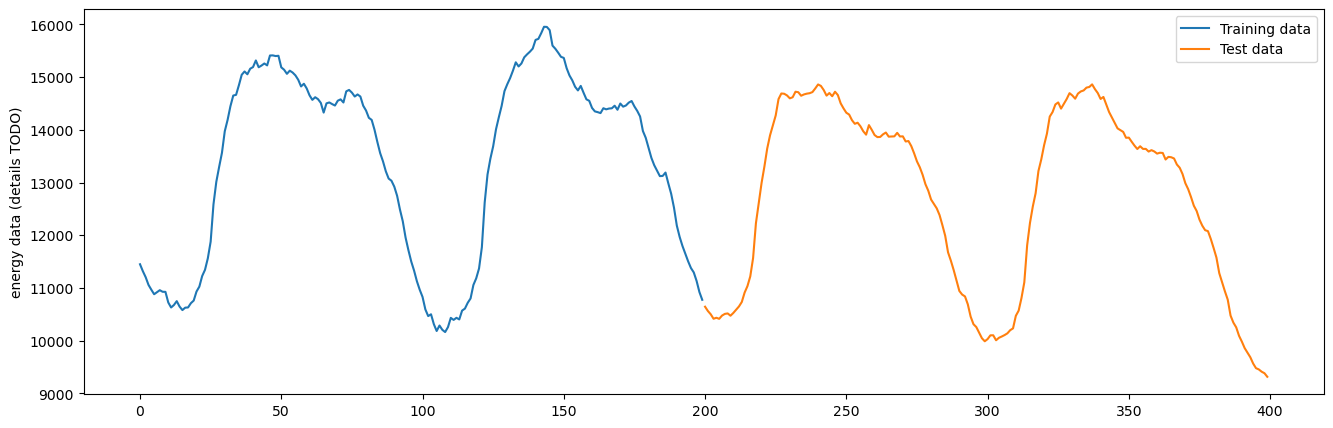

In [6]:
# visualize training and test sets

x_plot_train = np.arange(num_train_steps)
x_plot_test = x_plot_train + num_test_steps

plt.figure(figsize=(16, 5))
plt.plot(x_plot_train, y_train)
plt.plot(x_plot_test, y_test)
plt.ylabel("energy data (details TODO)")
plt.legend(["Training data", "Test data"])
plt.show()

## 2. Optimize the base estimator

Before estimating the prediction intervals with MAPIE, let's optimize the
base model, here a :class:`~RandomForestRegressor` through a
:class:`~RandomizedSearchCV` with a temporal cross-validation strategy.
For the sake of computational time, the best parameters are already tuned.



In [11]:
model_params_fit_not_done = False
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=3,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=26, n_estimators=45, random_state=59
        #max_depth=10, n_estimators=50, random_state=59
    )
print('done')
model

done


RandomForestRegressor(max_depth=26, n_estimators=45, random_state=59)

## 3. Estimate prediction intervals on the test set

We now use :class:`~MapieTimeSeriesRegressor` to build prediction intervals
associated with one-step ahead forecasts. As explained in the introduction,
we use the EnbPI method and the ACI method.

Estimating prediction intervals can be possible in three ways:

- with a regular ``.fit`` and ``.predict`` process, limiting the use of
  trainining set residuals to build prediction intervals

- using ``.partial_fit`` in addition to ``.fit`` and ``.predict`` allowing
  MAPIE to use new residuals from the test points as new data are becoming
  available.

- using ``.partial_fit`` and ``.adapt_conformal_inference`` in addition to
  ``.fit`` and ``.predict`` allowing MAPIE to use new residuals from the
  test points as new data are becoming available.

The latter method is particularly useful to adjust prediction intervals to
sudden change points on test sets that have not been seen by the model
during training.

We use the :class:`~BlockBootstrap` sampling
method instead of the traditional bootstrap strategy for training the model
since the former is more suited for time series data.
Here, we choose to perform 10 resamplings with 10 blocks.



In [12]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=10, n_blocks=10, overlapping=False, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)
mapie_aci = MapieTimeSeriesRegressor(
    model, method="aci", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

Let's start by estimating prediction intervals without partial fit.



In [43]:
import pickle
import os


def get_model(model, filename, skip_training=True):
    if skip_training:
        try:
            model = pickle.load(open(filename, 'rb'))
            print('loaded model')
            return model
        except FileNotFoundError:
            print(f'skipping training not possible')
    print('training...')
    model = model.fit(X_train, y_train)
    pickle.dump(model, open(filename, 'wb'))
    return model

def get_modelpath(filename):
    return os.path.join('models', filename)

# For EnbPI
skip_training_enbpi = True

mapie_enbpi = get_model(mapie_enbpi, get_modelpath('mapie_enbpi.model'), skip_training_enbpi)

print('predicting...')
y_pred_enbpi_npfit, y_pis_enbpi_npfit = mapie_enbpi.predict(
    X_test, alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=False
)

print('computing scores...')

# y_pis_enbpi_npfit = np.clip(y_pis_enbpi_npfit, 1, 10)

coverage_enbpi_npfit = regression_coverage_score(
    y_test, y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
)
width_enbpi_npfit = regression_mean_width_score(
    y_pis_enbpi_npfit[:, 0, 0], y_pis_enbpi_npfit[:, 1, 0]
)
cwc_enbpi_npfit = coverage_width_based(
    y_test, y_pis_enbpi_npfit[:, 0, 0],
    y_pis_enbpi_npfit[:, 1, 0],
    eta=10,
    alpha=0.05
)

loaded model
predicting...
computing scores...


In [44]:
# For ACI
skip_training_aci = True

mapie_aci = get_model(mapie_aci, get_modelpath('mapie_aci.model'), skip_training_aci)

y_pred_aci_npfit = np.zeros(y_pred_enbpi_npfit.shape)
y_pis_aci_npfit = np.zeros(y_pis_enbpi_npfit.shape)

print('predicting...')
y_pred_aci_npfit[:gap], y_pis_aci_npfit[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=False
)

print('looping...')
for step in range(gap, len(X_test), gap):
    if step % 10 == 0:
        print("step", step)
    mapie_aci.adapt_conformal_inference(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma=0.05
    )
    (
        y_pred_aci_npfit[step:step + gap],
        y_pis_aci_npfit[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=False
    )
    y_pis_aci_npfit[step:step + gap, :, :] = np.clip(y_pis_aci_npfit[step:step + gap, :, :], 1, 1e5)

print('computing scores...')
coverage_aci_npfit = regression_coverage_score(
    y_test, y_pis_aci_npfit[:, 0, 0], y_pis_aci_npfit[:, 1, 0]
)
width_aci_npfit = regression_mean_width_score(
    y_pis_aci_npfit[:, 0, 0], y_pis_aci_npfit[:, 1, 0]
)
cwc_aci_npfit = coverage_width_based(
    y_test,
    y_pis_aci_npfit[:, 0, 0],
    y_pis_aci_npfit[:, 1, 0],
    eta=10,
    alpha=0.05
)

loaded model
predicting...
looping...
step 10
step 20
step 30
step 40
step 50
step 60
step 70


ValueError: Number of samples of the score is too low,
1/alpha (or 1/(1 - alpha)) must be lower than the number of samples.

In [40]:
"""
# fix clipping
max_clipper = 5e4
for step in range(gap, len(X_test), gap):
    if np.any(y_pis_aci_npfit[step:step + gap, :, :] != np.clip(y_pis_aci_npfit[step:step + gap, :, :], 1, max_clipper)):
        print(f'clipping {y_pis_aci_npfit[step:step + gap, :, :]} to {np.clip(y_pis_aci_npfit[step:step + gap, :, :], 1, max_clipper)}')
    y_pis_aci_npfit[step:step + gap, :, :] = np.clip(y_pis_aci_npfit[step:step + gap, :, :], 1, max_clipper)
"""
...

Ellipsis

In [ ]:
# temp plot copy

y_enbpi_preds = [y_pred_enbpi_npfit, y_pred_enbpi_pfit]
y_enbpi_pis = [y_pis_enbpi_npfit, y_pis_enbpi_pfit]
coverages_enbpi = [coverage_enbpi_npfit, coverage_enbpi_pfit]
widths_enbpi = [width_enbpi_npfit, width_enbpi_pfit]

y_aci_preds = [y_pred_aci_npfit, y_pred_aci_pfit]
y_aci_pis = [y_pis_aci_npfit, y_pis_aci_pfit]
coverages_aci = [coverage_aci_npfit, coverage_aci_pfit]
widths_aci = [width_aci_npfit, width_aci_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Hourly demand (GW)")
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_enbpi_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_enbpi_pis[i][:, 0, 0],
        y_enbpi_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += (f"Coverage:{coverages_enbpi[i]:.3f} and "
              f"Width:{widths_enbpi[i]:.3f}")
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Hourly demand (GW)")
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_aci_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_aci_pis[i][:, 0, 0],
        y_aci_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"ACI, {w} update of residuals. "
    title += f"Coverage:{coverages_aci[i]:.3f} and Width:{widths_aci[i]:.3f}"
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
#[(i,x) for (i,x) in enumerate(y_pis_aci_npfit) if ~np.isinf(x).any()]

Let's now estimate prediction intervals with partial fit. As discussed
previously, the update of the residuals and the one-step ahead predictions
are performed sequentially in a loop.



In [ ]:
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)
print('fitting')
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_enbpi_pfit = np.zeros(y_pred_enbpi_npfit.shape)
y_pis_enbpi_pfit = np.zeros(y_pis_enbpi_npfit.shape)

print('predicting')
y_pred_enbpi_pfit[:gap], y_pis_enbpi_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=False
)

print('start loop')
for step in range(gap, len(X_test), gap):
    if step % 10 == 0:
        print("step", step)
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_enbpi_pfit[step:step + gap],
        y_pis_enbpi_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=False
    )
    # y_pis_enbpi_pfit[step:step + gap, :, :] = np.clip(y_pis_enbpi_pfit[step:step + gap, :, :], 1, 10)

print('computing scores')
coverage_enbpi_pfit = regression_coverage_score(
    y_test, y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)
width_enbpi_pfit = regression_mean_width_score(
    y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0]
)
cwc_enbpi_pfit = coverage_width_based(
    y_test, y_pis_enbpi_pfit[:, 0, 0], y_pis_enbpi_pfit[:, 1, 0],
    eta=10,
    alpha=0.05
)

Let's now estimate prediction intervals with adapt_conformal_inference.
As discussed previously, the update of the current alpha and the one-step
ahead predictions are performed sequentially in a loop.



In [ ]:
mapie_aci = MapieTimeSeriesRegressor(
    model, method="aci", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)
print('fitting')
mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci_pfit = np.zeros(y_pred_aci_npfit.shape)
y_pis_aci_pfit = np.zeros(y_pis_aci_npfit.shape)

print('predicting')
y_pred_aci_pfit[:gap], y_pis_aci_pfit[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=False
)

print('start loop')
for step in range(gap, len(X_test), gap):
    if step % 10 == 0:
        print("step", step)
    mapie_aci.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    mapie_aci.adapt_conformal_inference(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma=0.05
    )
    (
        y_pred_aci_pfit[step:step + gap],
        y_pis_aci_pfit[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=False
    )
    # y_pis_aci_pfit[step:step + gap, :, :] = np.clip(y_pis_aci_pfit[step:step + gap, :, :], 1, 10)

print('computing scores')
coverage_aci_pfit = regression_coverage_score(
    y_test, y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0]
)
width_aci_pfit = regression_mean_width_score(
    y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0]
)
cwc_aci_pfit = coverage_width_based(
    y_test, y_pis_aci_pfit[:, 0, 0], y_pis_aci_pfit[:, 1, 0],
    eta=0.01,
    alpha=0.05
)

## 4. Plot estimated prediction intervals on one-step ahead forecast

Let's now compare the prediction intervals estimated by MAPIE with and
without update of the residuals.



In [ ]:
y_enbpi_preds = [y_pred_enbpi_npfit, y_pred_enbpi_pfit]
y_enbpi_pis = [y_pis_enbpi_npfit, y_pis_enbpi_pfit]
coverages_enbpi = [coverage_enbpi_npfit, coverage_enbpi_pfit]
widths_enbpi = [width_enbpi_npfit, width_enbpi_pfit]

y_aci_preds = [y_pred_aci_npfit, y_pred_aci_pfit]
y_aci_pis = [y_pis_aci_npfit, y_pis_aci_pfit]
coverages_aci = [coverage_aci_npfit, coverage_aci_pfit]
widths_aci = [width_aci_npfit, width_aci_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Hourly demand (GW)")
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_enbpi_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_enbpi_pis[i][:, 0, 0],
        y_enbpi_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += (f"Coverage:{coverages_enbpi[i]:.3f} and "
              f"Width:{widths_enbpi[i]:.3f}")
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Hourly demand (GW)")
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_aci_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_aci_pis[i][:, 0, 0],
        y_aci_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"ACI, {w} update of residuals. "
    title += f"Coverage:{coverages_aci[i]:.3f} and Width:{widths_aci[i]:.3f}"
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

Let's now compare the coverages obtained by MAPIE with and without update
of the residuals on a 24-hour rolling window of prediction intervals.



In [ ]:
rolling_coverage_aci_pfit, rolling_coverage_aci_npfit = [], []
rolling_coverage_enbpi_pfit, rolling_coverage_enbpi_npfit = [], []

window = 24

for i in range(window, len(y_test), 1):
    rolling_coverage_aci_npfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_aci_npfit[i-window:i, 0, 0],
            y_pis_aci_npfit[i-window:i, 1, 0]
        )
    )
    rolling_coverage_aci_pfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_aci_pfit[i-window:i, 0, 0],
            y_pis_aci_pfit[i-window:i, 1, 0]
        )
    )

    rolling_coverage_enbpi_npfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_enbpi_npfit[i-window:i, 0, 0],
            y_pis_enbpi_npfit[i-window:i, 1, 0]
        )
    )
    rolling_coverage_enbpi_pfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_enbpi_pfit[i-window:i, 0, 0],
            y_pis_enbpi_pfit[i-window:i, 1, 0]
        )
    )

plt.figure(figsize=(10, 5))
plt.ylabel(f"Rolling coverage [{window} hours]")

plt.plot(
    y_test[window:].index,
    rolling_coverage_aci_npfit,
    label="ACI Without update of residuals (NPfit)",
    linestyle='--', color='r', alpha=0.5
)
plt.plot(
    y_test[window:].index,
    rolling_coverage_aci_pfit,
    label="ACI With update of residuals (Pfit)",
    linestyle='-', color='r', alpha=0.5
)

plt.plot(
    y_test[window:].index,
    rolling_coverage_enbpi_npfit,
    label="ENBPI Without update of residuals (NPfit)",
    linestyle='--', color='b', alpha=0.5
)
plt.plot(
    y_test[window:].index,
    rolling_coverage_enbpi_pfit,
    label="ENBPI With update of residuals (Pfit)",
    linestyle='-', color='b', alpha=0.5
)

plt.legend()
plt.show()